In [1]:
!pip install missingno


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler




In [30]:
def load_application_train():
    data = pd.read_csv("datasets/application_train.csv")
    return data



def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data

In [33]:
df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


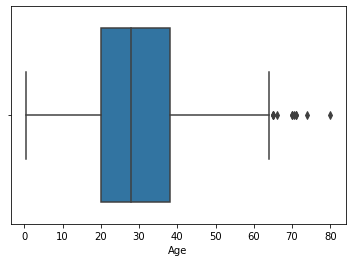

False

In [34]:
# Grafik Teknikle Aykırı Değerler
###################

sns.boxplot(x=df["Age"])
plt.show()

###################
# Aykırı Değerler Nasıl Yakalanır?
###################

q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

df[(df["Age"] < low) | (df["Age"] > up)]

df[(df["Age"] < low) | (df["Age"] > up)].index

###################
# Aykırı Değer Var mı Yok mu?
###################

df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None)
df[(df["Age"] < low)].any(axis=None)

# 1. Eşik değer belirledik.
# 2. Aykırılara eriştik.
# 3. Hızlıca aykırı değer var mı yok diye sorduk.


In [35]:
###################
# İşlemleri Fonksiyonlaştırmak
###################


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

outlier_thresholds(df, "Age")
outlier_thresholds(df, "Fare")

low, up = outlier_thresholds(df, "Fare")

df[(df["Fare"] < low) | (df["Fare"] > up)].head()


df[(df["Fare"] < low) | (df["Fare"] > up)].index

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df, "Age")
check_outlier(df, "Fare")


True

In [37]:
dff = load_application_train()
dff.head()


def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]

for col in num_cols:
    print(col, check_outlier(df, col))


cat_cols, num_cols, cat_but_car = grab_col_names(dff)

num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]

for col in num_cols:
    print(col, check_outlier(dff, col))

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True
Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39
CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FL

In [41]:
# Aykırı Değerlerin Kendilerine Erişmek
###################

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

grab_outliers(df, "Age")

grab_outliers(df, "Age", True)

age_index = grab_outliers(df, "Age", True)


outlier_thresholds(df, "Age")
check_outlier(df, "Age")
grab_outliers(df, "Age", True)

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  
     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55   

Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [42]:
# Aykırı Değer Problemini Çözme
#############################################

###################
# Silme
###################

low, up = outlier_thresholds(df, "Fare")
df.shape

df[~((df["Fare"] < low) | (df["Fare"] > up))].shape

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]

df.shape

for col in num_cols:
    new_df = remove_outlier(df, col)

df.shape[0] - new_df.shape[0]

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


116

In [43]:
# Baskılama Yöntemi (re-assignment with thresholds)
###################

low, up = outlier_thresholds(df, "Fare")

df[((df["Fare"] < low) | (df["Fare"] > up))]["Fare"]

df.loc[((df["Fare"] < low) | (df["Fare"] > up)), "Fare"]

df.loc[(df["Fare"] > up), "Fare"] = up

df.loc[(df["Fare"] < low), "Fare"] = low

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

df = load()
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]

df.shape

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))


Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True
Age False
Fare False


In [44]:
# Eksik Değerlerin Yakalanması

df = load()
df.head()

# eksik gozlem var mı yok mu sorgusu
df.isnull().values.any()

# degiskenlerdeki eksik deger sayisi
df.isnull().sum()

# degiskenlerdeki tam deger sayisi
df.notnull().sum()

# veri setindeki toplam eksik deger sayisi
df.isnull().sum().sum()

# en az bir tane eksik degere sahip olan gözlem birimleri
df[df.isnull().any(axis=1)]

# tam olan gözlem birimleri
df[df.notnull().all(axis=1)]

# Azalan şekilde sıralamak
df.isnull().sum().sort_values(ascending=False)

(df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)

na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]

In [45]:
#Yukaridaki işlemlerin fonksiyonlaştırılması

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(df)

missing_values_table(df, True)

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22
          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


['Age', 'Cabin', 'Embarked']

In [46]:
# Eksik Değer Problemini Çözme
missing_values_table(df)

# Çözüm 1: Hızlıca silmek
df.dropna().shape

# Çözüm 2: Basit Atama Yöntemleri ile Doldurmak

df["Age"].fillna(df["Age"].mean()).isnull().sum()
df["Age"].fillna(df["Age"].median()).isnull().sum()
df["Age"].fillna(0).isnull().sum()

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


0

In [48]:
# Kategorik Değişken Kırılımında Değer Atama

df.groupby("Sex")["Age"].mean()

df["Age"].mean()

df["Age"].fillna(df.groupby("Sex")["Age"].transform("mean")).isnull().sum()

df.groupby("Sex")["Age"].mean()["female"]

df.loc[(df["Age"].isnull()) & (df["Sex"]=="female"), "Age"] = df.groupby("Sex")["Age"].mean()["female"]

df.loc[(df["Age"].isnull()) & (df["Sex"]=="male"), "Age"] = df.groupby("Sex")["Age"].mean()["male"]

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [49]:
#3 Encoding (label Encoding, ONe-HOt Encodinh ,Rare Encoding)
#Encoding değişkenlerin temsil şekillerinin değiştirilmesi

def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data

df=load()
df.head()

df["Sex"].head()


le= LabelEncoder()
le.fit_transform(df["Sex"])[0:5]

le.inverse_transform([0, 1])  #Eğer ki uygulanan transferin karşıluklarını öğrenmek istersek.


array(['female', 'male'], dtype=object)

In [50]:
#Yukarıdaki işlemi fonksiyon haline getirmek
def label_encoder(dataframe,binary_col):
    label_encoder=LabelEncoder()
    dataframe[binary_col]=label_encoder.fit_transform(dataframe[binary_col])
    return dataframe


In [51]:

binary_cols = [col for col in df.columns if df[col].dtype not in [int,float] and df[col].nunique() == 2]

In [52]:
for col in binary_cols:
    label_encoder(df, col)

In [53]:
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [54]:
#One -Hot Encoding  
#Eğer ki değişkenlerimiz ordinal değilse ve ordinal yani label encoding yaparsak hata yapmış oluruz.

df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [55]:
pd.get_dummies(df, columns=["Embarked"]).head() #dummy değişken oluşuturuyoruz.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1


In [56]:
pd.get_dummies(df, columns=["Embarked"], drop_first=True).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,1


In [57]:
pd.get_dummies(df, columns=["Embarked"], dummy_na=True).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1,0


In [58]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [59]:
df = load()

In [60]:
# cat_cols, num_cols, cat_but_car = grab_col_names(df)

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [61]:
one_hot_encoder(df, ohe_cols).head()

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [62]:
# Rare Encoding
#############################################

# 1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.
# 2. Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.
# 3. Rare encoder yazacağız.

###################
# 1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.
###################

df = load_application_train()
df["NAME_EDUCATION_TYPE"].value_counts()

cat_cols, num_cols, cat_but_car = grab_col_names(df)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)


Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39
                 NAME_CONTRACT_TYPE      Ratio
Cash loans                   278232  90.478715
Revolving loans               29279   9.521285
##########################################
     CODE_GENDER      Ratio
F         202448  65.834393
M         105059  34.164306
XNA            4   0.001301
##########################################
   FLAG_OWN_CAR      Ratio
N        202924  65.989184
Y        104587  34.010816
##########################################
   FLAG_OWN_REALTY      Ratio
Y           213312  69.367275
N            94199  30.632725
##########################################
                 NAME_TYPE_SUITE      Ratio
Unaccompanied             248526  80.818572
Family                     40149  13.056118
Spouse, partner            11370   3.697429
Children                    3267   1.062401
Other_B                     1770   0.575589
Other_A                      866   0.281616
Gro

In [63]:

#2.Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.
df["NAME_CONTRACT_TYPE"].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [64]:
df.groupby("NAME_INCOME_TYPE")["TARGET"].mean()


NAME_INCOME_TYPE
Businessman             0.000000
Commercial associate    0.074843
Maternity leave         0.400000
Pensioner               0.053864
State servant           0.057550
Student                 0.000000
Unemployed              0.363636
Working                 0.095885
Name: TARGET, dtype: float64

In [65]:
def rare_analyser(dataframe,target,cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [66]:
rare_analyser(df, "TARGET", cat_cols)

NAME_CONTRACT_TYPE : 2
                     COUNT     RATIO  TARGET_MEAN
NAME_CONTRACT_TYPE                               
Cash loans          278232  0.904787     0.083459
Revolving loans      29279  0.095213     0.054783


CODE_GENDER : 3
              COUNT     RATIO  TARGET_MEAN
CODE_GENDER                               
F            202448  0.658344     0.069993
M            105059  0.341643     0.101419
XNA               4  0.000013     0.000000


FLAG_OWN_CAR : 2
               COUNT     RATIO  TARGET_MEAN
FLAG_OWN_CAR                               
N             202924  0.659892     0.085002
Y             104587  0.340108     0.072437


FLAG_OWN_REALTY : 2
    COUNT     RATIO  TARGET_MEAN
N   94199  0.306327     0.083249
Y  213312  0.693673     0.079616


NAME_TYPE_SUITE : 7
                  COUNT     RATIO  TARGET_MEAN
Children           3267  0.010624     0.073768
Family            40149  0.130561     0.074946
Group of people     271  0.000881     0.084871
Other_A           

In [67]:
# 3. Rare encoder'ın yazılması.

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

new_df = rare_encoder(df, 0.01)

rare_analyser(new_df, "TARGET", cat_cols)

df["OCCUPATION_TYPE"].value_counts()

NAME_CONTRACT_TYPE : 2
                     COUNT     RATIO  TARGET_MEAN
NAME_CONTRACT_TYPE                               
Cash loans          278232  0.904787     0.083459
Revolving loans      29279  0.095213     0.054783


CODE_GENDER : 3
              COUNT     RATIO  TARGET_MEAN
CODE_GENDER                               
F            202448  0.658344     0.069993
M            105059  0.341643     0.101419
Rare              4  0.000013     0.000000


FLAG_OWN_CAR : 2
               COUNT     RATIO  TARGET_MEAN
FLAG_OWN_CAR                               
N             202924  0.659892     0.085002
Y             104587  0.340108     0.072437


FLAG_OWN_REALTY : 2
    COUNT     RATIO  TARGET_MEAN
N   94199  0.306327     0.083249
Y  213312  0.693673     0.079616


NAME_TYPE_SUITE : 5
                  COUNT     RATIO  TARGET_MEAN
Children           3267  0.010624     0.073768
Family            40149  0.130561     0.074946
Rare               2907  0.009453     0.093911
Spouse, partner   

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [68]:
# Feature Scaling (Özellik Ölçeklendirme)
# StandardScaler: Klasik standartlaştırma. Ortalamayı çıkar, standart sapmaya böl. z = (x - u) / s
df = load()
ss = StandardScaler()
df["Age_standard_scaler"] = ss.fit_transform(df[["Age"]])
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_standard_scaler
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,-0.530377
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.571831
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,-0.254825
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.365167
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.365167


In [69]:
# RobustScaler: Medyanı çıkar iqr'a böl.

rs = RobustScaler()
df["Age_robuts_scaler"] = rs.fit_transform(df[["Age"]])
df.describe().T


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,4.460000e+02,257.353842,1.000000,223.500000,446.000000,668.500000,891.000000
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.0,2.308642e+00,0.836071,1.000000,2.000000,3.000000,3.000000,3.000000
Age,714.0,2.969912e+01,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
SibSp,891.0,5.230079e-01,1.102743,0.000000,0.000000,0.000000,1.000000,8.000000
Parch,891.0,3.815937e-01,0.806057,0.000000,0.000000,0.000000,0.000000,6.000000
Fare,891.0,3.220421e+01,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200
Age_standard_scaler,714.0,2.174187e-16,1.000701,-2.016979,-0.659542,-0.117049,0.571831,3.465126
Age_robuts_scaler,714.0,9.505553e-02,0.812671,-1.542937,-0.440559,0.000000,0.559441,2.909091


In [70]:
# MinMaxScaler: Verilen 2 değer arasında değişken dönüşümü

# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

mms = MinMaxScaler()
df["Age_min_max_scaler"] = mms.fit_transform(df[["Age"]])
df.describe().T

df.head()

age_cols = [col for col in df.columns if "Age" in col]

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
5%         4.000000
10%       14.000000
20%       19.000000
30%       22.000000
40%       25.000000
50%       28.000000
60%       31.800000
70%       36.000000
80%       41.000000
90%       50.000000
95%       56.000000
99%       65.870000
max       80.000000
Name: Age, dtype: float64


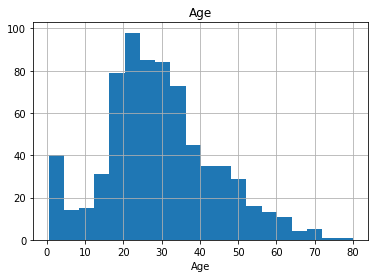

count    7.140000e+02
mean     2.174187e-16
std      1.000701e+00
min     -2.016979e+00
5%      -1.770360e+00
10%     -1.081480e+00
20%     -7.370406e-01
30%     -5.303766e-01
40%     -3.237127e-01
50%     -1.170488e-01
60%      1.447255e-01
70%      4.340550e-01
80%      7.784949e-01
90%      1.398487e+00
95%      1.811815e+00
99%      2.491739e+00
max      3.465126e+00
Name: Age_standard_scaler, dtype: float64


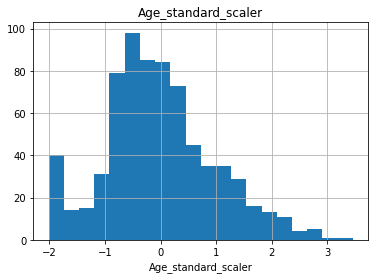

count    714.000000
mean       0.095056
std        0.812671
min       -1.542937
5%        -1.342657
10%       -0.783217
20%       -0.503497
30%       -0.335664
40%       -0.167832
50%        0.000000
60%        0.212587
70%        0.447552
80%        0.727273
90%        1.230769
95%        1.566434
99%        2.118601
max        2.909091
Name: Age_robuts_scaler, dtype: float64


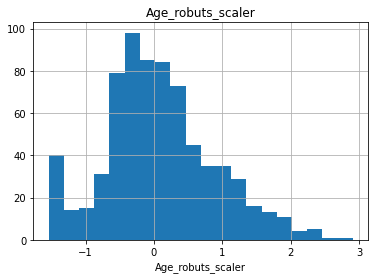

count    714.000000
mean       0.367921
std        0.182540
min        0.000000
5%         0.044986
10%        0.170646
20%        0.233476
30%        0.271174
40%        0.308872
50%        0.346569
60%        0.394320
70%        0.447097
80%        0.509927
90%        0.623021
95%        0.698417
99%        0.822443
max        1.000000
Name: Age_min_max_scaler, dtype: float64


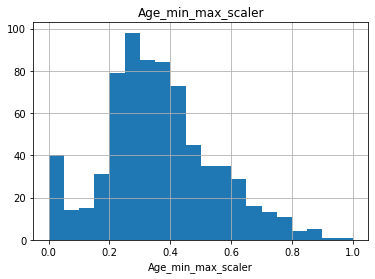

In [71]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in age_cols:
    num_summary(df, col, plot=True)


In [72]:
# Numeric to Categorical: Sayısal Değişkenleri Kateorik Değişkenlere Çevirme
# Binning

df["Age_qcut"] = pd.qcut(df['Age'], 5)

In [73]:
df["Age_qcut"]

0       (19.0, 25.0]
1       (31.8, 41.0]
2       (25.0, 31.8]
3       (31.8, 41.0]
4       (31.8, 41.0]
           ...      
886     (25.0, 31.8]
887    (0.419, 19.0]
888              NaN
889     (25.0, 31.8]
890     (31.8, 41.0]
Name: Age_qcut, Length: 891, dtype: category
Categories (5, interval[float64]): [(0.419, 19.0] < (19.0, 25.0] < (25.0, 31.8] < (31.8, 41.0] < (41.0, 80.0]]

In [74]:
#Feature Extraction (Özellik Çıkarımı):Ham veriden değişken,özellik,feature türetmek anlamına geliyor.
# Binary Features: Flag, Bool, True-False

df = load()
df.head()

df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')


In [75]:

df["NEW_CABIN_BOOL"] 

0      0
1      1
2      0
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: NEW_CABIN_BOOL, Length: 891, dtype: int64

In [76]:
df.groupby("NEW_CABIN_BOOL").agg({"Survived": "mean"})

,Survived
NEW_CABIN_BOOL,
0,0.299854
1,0.666667


In [80]:
from statsmodels.stats.proportion import proportions_ztest


test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].sum(),
                                             df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].shape[0],
                                            df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 9.4597, p-value = 0.0000


In [82]:

df.loc[((df['SibSp'] + df['Parch']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SibSp'] + df['Parch']) == 0), "NEW_IS_ALONE"] = "YES"
df.groupby("NEW_IS_ALONE").agg({"Survived": "mean"})

,Survived
NEW_IS_ALONE,
NO,0.505650
YES,0.303538


In [83]:
test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].sum(),
                                             df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].shape[0],
                                            df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = -6.0704, p-value = 0.0000


In [85]:
# Text'ler Üzerinden Özellik Türetmek

df.head()

# Letter Count

df["NEW_NAME_COUNT"] = df["Name"].str.len()

In [86]:

df["NEW_NAME_COUNT"] 

0      23
1      51
2      22
3      44
4      24
       ..
886    21
887    28
888    40
889    21
890    19
Name: NEW_NAME_COUNT, Length: 891, dtype: int64

In [87]:
# Word Count
df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))

In [93]:
#Date Değişkenleri Üretmek


dff = pd.read_csv("datasets/course_reviews.csv")
dff.head()
dff.info()

dff['Timestamp'] = pd.to_datetime(dff["Timestamp"], format="%Y-%m-%d")

# year
dff['year'] = dff['Timestamp'].dt.year

# month
dff['month'] = dff['Timestamp'].dt.month

# year diff
dff['year_diff'] = date.today().year - dff['Timestamp'].dt.year

# month diff (iki tarih arasındaki ay farkı): yıl farkı + ay farkı
dff['month_diff'] = (date.today().year - dff['Timestamp'].dt.year) * 12 + date.today().month - dff['Timestamp'].dt.month


# day name
dff['day_name'] = dff['Timestamp'].dt.day_name()

dff.head()

# date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rating              4323 non-null   float64
 1   Timestamp           4323 non-null   object 
 2   Enrolled            4323 non-null   object 
 3   Progress            4323 non-null   float64
 4   Questions Asked     4323 non-null   float64
 5   Questions Answered  4323 non-null   float64
dtypes: float64(4), object(2)
memory usage: 202.8+ KB


,Rating,Timestamp,Enrolled,Progress,Questions Asked,Questions Answered,year,month,year_diff,month_diff,day_name
0,5.0,2021-02-05 07:45:55,2021-01-25 15:12:08,5.0,0.0,0.0,2021,2,3,35,Friday
1,5.0,2021-02-04 21:05:32,2021-02-04 20:43:40,1.0,0.0,0.0,2021,2,3,35,Thursday
2,4.5,2021-02-04 20:34:03,2019-07-04 23:23:27,1.0,0.0,0.0,2021,2,3,35,Thursday
3,5.0,2021-02-04 16:56:28,2021-02-04 14:41:29,10.0,0.0,0.0,2021,2,3,35,Thursday
4,4.0,2021-02-04 15:00:24,2020-10-13 03:10:07,10.0,0.0,0.0,2021,2,3,35,Thursday
